In [1]:
from PIL import Image

# 0-a) preparation

## we use some python tools that may be dependent on library versions. To avoid conflicts with other installed python libraries, I recommend you prepare anaconda
## $\circ$ let's make an environment for vamp_dpp

conda create -n vamp_dpp python=3.11 jupyter mkl-service

### jupyter is essential to run this demo code
### installing mkl-service is also recommended when running pyklip
## then activate the environment

# 0-b) installation of VAMP DPP and pyklip

## $\circ$VAMPIRES DPP (https://scexao-org.github.io/vampires_dpp/installation.html)
pip install -U git+https://github.com/scexao-org/vampires_dpp.git

## $\circ$pyklip (https://pyklip.readthedocs.io/en/latest/install.html)
pip install pyklip

### optional: a future pyklip version will implement VAMPIRES data class, but it is still under development (unavailable in the public version). If you are interested in running, install it via Miles' github (https://github.com/mileslucas/pyklip/tree/ml/vampires)
### you may need to install git-lfs in advance to avoid errors (https://git-lfs.com/)
GIT_LFS_SKIP_SMUDGE=1 git clone https://github.com/mileslucas/pyklip.git pyklip-vampires  
cd pyklip-vampires  
git checkout ml/vampires  
pip install -e . 

# 0-c) what we want to do with the VAMPIRES data set?

## They're designated for AO-fed high angular-resolution/contrast imaging
### for high-contrast, we need post-processing (differential imaging) to subtract stellar PSF that hides faint disk/planet signals.

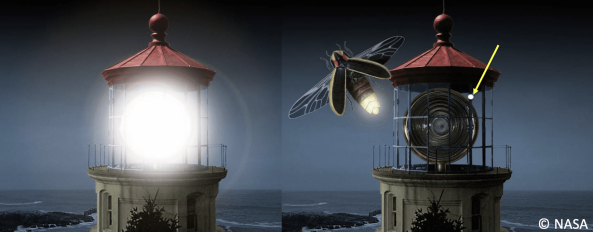

In [2]:
Image.open('figures_tutorial/lighthouse.png').reduce(3)

## the concept of differential imaging

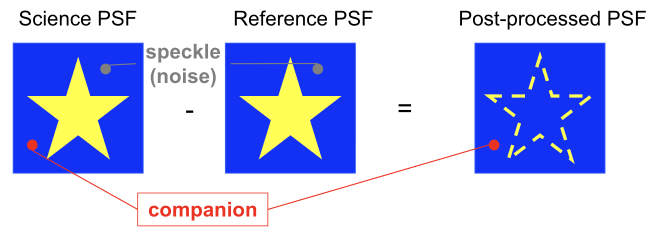

In [3]:
Image.open('figures_tutorial/differential_imaging.png').reduce(2)

## flowchart of high-contrast imaging

Image credit: C. Marois


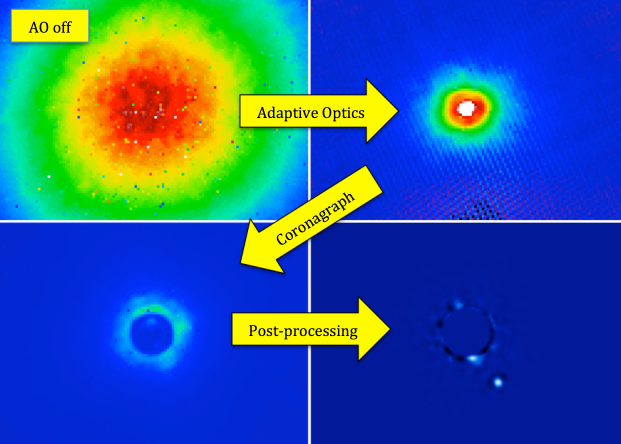

In [4]:
print('Image credit: C. Marois')
Image.open('figures_tutorial/schematic.jpg').reduce(3)

## VAMPIRES H$\alpha$ / H$\alpha$_cont simultaneous imaging
## We will implement angular differential imaging (ADI) and spectral differential imaging (SDI)
### The new H$\alpha$ filter is replaced in January 2020

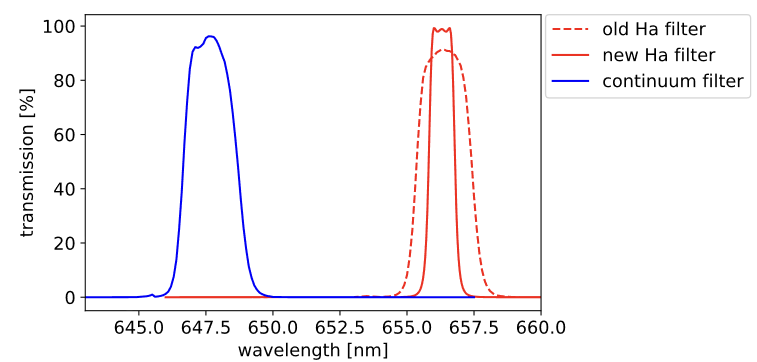

In [5]:
Image.open('figures_tutorial/VAMP_filters.png').reduce(2)

## Conlusion: We will obtain high-contrast H$\alpha$ and H$\alpha$_cont images via ADI, then apply SDI (if we expect to detect something only at Ha)

# 1) calibrating the raw data
## let's get started on handling actual VAMPIRES data.
## $\circ$Target: AB Aur (DO NOT SHARE OUTSIDE!!)
## $\circ$Obs date: Nov 22, 2024 UT
## $\circ$Configuration: Ha/Ha_cont PDI
### - we will not reduce PDI, but simply combine polarimetric images into total intensity this time.

## a) sort data

### first, download the raw data from the link in README, and confirm you have the raw data at ./tutorial_raw

In [6]:
ls tutorial_raw/

VMPA00259500.fits  VMPA00259747.fits  VMPA00259994.fits  VMPA00260507.fits
VMPA00259501.fits  VMPA00259748.fits  VMPA00259995.fits  VMPA00260508.fits
VMPA00259502.fits  VMPA00259749.fits  VMPA00259996.fits  VMPA00260509.fits
VMPA00259503.fits  VMPA00259750.fits  VMPA00259997.fits  VMPA00260510.fits
VMPA00259504.fits  VMPA00259751.fits  VMPA00259998.fits  VMPA00260511.fits
VMPA00259505.fits  VMPA00259752.fits  VMPA00259999.fits  VMPA00260512.fits
VMPA00259506.fits  VMPA00259753.fits  VMPA00260000.fits  VMPA00260513.fits
VMPA00259507.fits  VMPA00259754.fits  VMPA00260001.fits  VMPA00260514.fits
VMPA00259508.fits  VMPA00259755.fits  VMPA00260002.fits  VMPA00260515.fits
VMPA00259509.fits  VMPA00259756.fits  VMPA00260003.fits  VMPA00260516.fits
VMPA00259510.fits  VMPA00259757.fits  VMPA00260004.fits  VMPA00260517.fits
VMPA00259511.fits  VMPA00259758.fits  VMPA00260005.fits  VMPA00260518.fits
VMPA00259512.fits  VMPA00259759.fits  VMPA00260006.fits  VMPA00260519.fits
VMPA00259513.fits  VMPA00

In [20]:
! yes N | dpp sort tutorial_raw/*fits -o sorted/ -c 

Sorting files: 100%|██████████████████████████| 993/993 [00:49<00:00, 20.00it/s]
yes: stdout: Broken pipe


### note: ignore the broken pipe message. -c means making copies (leave the raw files in the original directory). if you don't need to copy use -nc option instead.
### you see './sorted' directory after frame sorting

## b) create calibration files

In [21]:
! dpp calib -o master_cals back sorted/darks/*/*fits

Collapsing background frames: 100%|███████████████| 8/8 [01:52<00:00, 14.11s/it]


### you see './master_cals' directory where the calibration files are stored

## c) prepare the configurations ('dpp new' works only on command-line interface)

In [22]:
from vampires_dpp.pipeline import config
from astroquery.simbad import Simbad
Simbad.add_votable_fields('V','RA','Dec','pmra','pmdec','parallax','sp_type')
from astropy.coordinates import SkyCoord
import astropy.units as u

target_name = 'AB_Aur'

## extract AB Aur information from Simbad

In [23]:
simbad_result = Simbad.query_object(target_name)
c = SkyCoord(ra=simbad_result['ra'][0]*u.deg,dec=simbad_result['dec'][0]*u.deg)
ra = c.ra.to_string(unit=u.hour, sep=':',precision=2)
dec = c.dec.to_string(unit=u.deg, sep=':',precision=2)
pmra = simbad_result['pmra'][0]
pmdec = simbad_result['pmdec'][0]
parallax = simbad_result['plx_value'][0]
sptype = simbad_result['sp_type'][0]
if len(sptype)>3:
    sptype=sptype[0:3]
Vmag = simbad_result['V'][0]

## prepare the configuration file

In [24]:
cfg = config.PipelineConfig
target = config.TargetConfig(name=target_name,ra=ra,dec=dec,pm_ra=pmra,pm_dec=pmdec,parallax=parallax)

config_ABAur = cfg(name=target_name,target=target)
config_ABAur.calibrate.calib_directory='master_cals/'
config_ABAur.save_adi_cubes=True

### if you want to do frame selection, change to True ###
config_ABAur.frame_select.frame_select=False
config_ABAur.frame_select.metric='strehl'
config_ABAur.frame_select.cutoff=0.0
config_ABAur.frame_select.save_intermediate=False
#########################
config_ABAur.specphot.unit='Jy/arcsec^2'
config_ABAur.specphot.sptype=sptype
config_ABAur.specphot.mag=Vmag
config_ABAur.specphot.mag_band='V'

config_ABAur.save('./'+target_name+'.toml')

### if you want to reduce pdi, set 'diff_images' and 'polarimetry' keywords
### https://scexao-org.github.io/vampires_dpp/configuration.html#id2

## d) Prepare image centroids estimates

## you need to run 'dpp centroid' for each filter data because this data set is Ha-SDI+PDI that is not fully supported by the current DPP version
## also make different output directories

### note: if you're calibrating MBI (non-SDI) data, you can simply follow the instruction of VAMPIRES DPP, no need to separately run 'dpp centroid' and 'dpp run'

### d-1) Ha data

In [25]:
! dpp centroid AB_Aur.toml -np sorted/ABAUR/Open_Halpha_000200102us_536x536/*fits -o Ha

Parsing FITS headers: 100%|███████████████████| 492/492 [00:09<00:00, 52.89it/s]
[12:47:06.694] Loading raw PSF frame from Ha/aux/AB_Aur_mean_image_cam1.fits
[12:47:06.699] Loading raw PSF frame from Ha/aux/AB_Aur_mean_image_cam2.fits
[12:47:06.733] Making synthetic PSF for Halpha
[12:47:07.168] Making synthetic PSF for Halpha
[12:47:07.602] Saved cam1 centroids to Ha/aux/AB_Aur_centroids_cam1.toml
[12:47:07.603] Saved cam2 centroids to Ha/aux/AB_Aur_centroids_cam2.toml


### d-2) Ha-cont data

In [26]:
! dpp centroid AB_Aur.toml -np sorted/ABAUR/Open_Ha-Cont_000200102us_536x536/*fits -o Ha-cont

Parsing FITS headers: 100%|███████████████████| 493/493 [00:09<00:00, 50.83it/s]
[12:47:20.992] Loading raw PSF frame from Ha-cont/aux/AB_Aur_mean_image_cam1.fits
[12:47:20.999] Loading raw PSF frame from Ha-cont/aux/AB_Aur_mean_image_cam2.fits
[12:47:21.039] Making synthetic PSF for Ha-Cont
[12:47:21.529] Making synthetic PSF for Ha-Cont
[12:47:21.917] Saved cam1 centroids to Ha-cont/aux/AB_Aur_centroids_cam1.toml
[12:47:21.917] Saved cam2 centroids to Ha-cont/aux/AB_Aur_centroids_cam2.toml


## e) run the main function of VAMPIRES DPP with the configuration file
### see the DPP tutorial for the processing steps (can be modified in the config file)
### https://scexao-org.github.io/vampires_dpp/quickstart.html#running-the-pipeline

### e-1) Ha data

In [27]:
! dpp run AB_Aur.toml sorted/ABAUR/Open_Halpha_000200102us_536x536/*fits -o Ha

[12:47:25.658] VAMPIRES DPP: v0.14.1
[12:47:25.659] Using 1 processes
[12:47:25.659] Note: a detailed log can be found in Ha/debug.log
[12:47:25.659] Tip: watch it live with `tail -f Ha/debug.log`
[12:47:36.014] Saved input header table to: Ha/aux/AB_Aur_input_headers.csv
[12:47:36.204] Saved file combination table to /Volumes/data_astro/analysis_VAMPIRES/tutorial/Ha/aux/AB_Aur_file_combinations.csv
Processing files: 100%|███████████████████████| 492/492 [08:20<00:00,  1.02s/it]
[12:56:18.042] Creating table from output headers
[12:56:30.022] Saved output header table to Ha/aux/AB_Aur_table.csv
[12:56:30.034] Stacking output files into ADI cubes
Loading and combining both cams: 100%|████████| 492/492 [00:57<00:00,  8.55it/s]
[12:57:35.179] Saved ADI cube to Ha/adi/AB_Aur_adi_cube.fits
[12:57:35.353] Finished processing files


### e-2) Ha-cont data

In [28]:
! dpp run AB_Aur.toml sorted/ABAUR/Open_Ha-Cont_000200102us_536x536/*fits -o Ha-cont

[12:57:41.258] VAMPIRES DPP: v0.14.1
[12:57:41.260] Using 1 processes
[12:57:41.260] Note: a detailed log can be found in Ha-cont/debug.log
[12:57:41.261] Tip: watch it live with `tail -f Ha-cont/debug.log`
[12:57:51.547] Saved input header table to: Ha-cont/aux/AB_Aur_input_headers.csv
[12:57:51.691] Saved file combination table to /Volumes/data_astro/analysis_VAMPIRES/tutorial/Ha-cont/aux/AB_Aur_file_combinations.csv
Processing files: 100%|███████████████████████| 493/493 [08:28<00:00,  1.03s/it]
[01:06:29.139] Creating table from output headers
[01:06:43.264] Saved output header table to Ha-cont/aux/AB_Aur_table.csv
[01:06:43.282] Stacking output files into ADI cubes
Loading and combining both cams: 100%|████████| 493/493 [00:51<00:00,  9.58it/s]
[01:07:41.092] Saved ADI cube to Ha-cont/adi/AB_Aur_adi_cube.fits
[01:07:41.258] Finished processing files


# let's see what you got after dpp run
### i.e. registed sets of the calibrated frames, and the list of the parallactic angle

In [29]:
! ls Ha/adi/*fits
! ls Ha-cont/adi/*fits

Ha/adi/AB_Aur_adi_angles.fits Ha/adi/AB_Aur_adi_cube.fits
Ha-cont/adi/AB_Aur_adi_angles.fits Ha-cont/adi/AB_Aur_adi_cube.fits


# display the Ha output

In [30]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np

### the first frame of the data

the number of the frames: 492


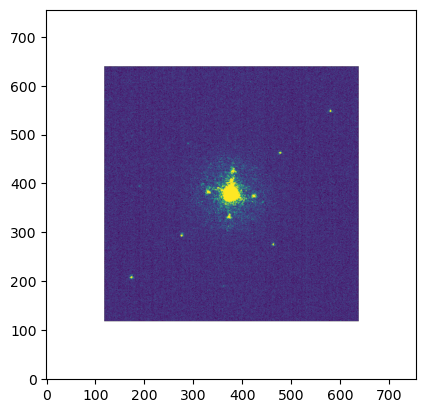

In [31]:
Ha_datalist = fits.getdata('Ha/adi/AB_Aur_adi_cube.fits')
print(f'the number of the frames: {len(Ha_datalist)}')
plt.imshow(Ha_datalist[0][0],vmin=np.nanpercentile(Ha_datalist[0][0],0.5),vmax=np.nanpercentile(Ha_datalist[0][0],99.5),origin='lower')

### the list of the parallactic angle'

## you can assume the parallactic angle as the field orientation during ADI observations

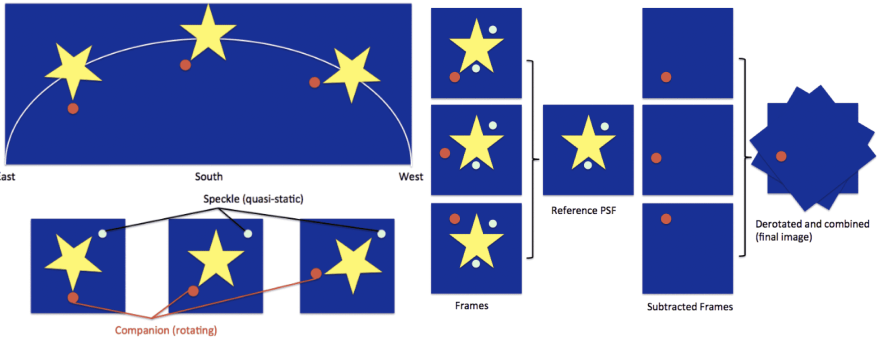

In [32]:
Image.open('figures_tutorial/ADI_concept.png').reduce(2)

### if you want to know details about parallactic angle, check this page; https://www2.keck.hawaii.edu/inst/common/parallactic.html

rotation angle: 44.248443603515625 deg


Text(0, 0.5, 'parallctic angle [deg]')

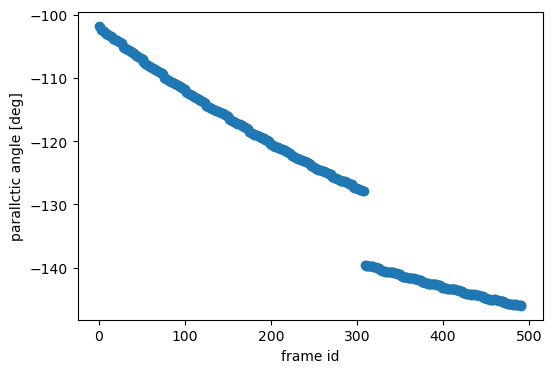

In [33]:
anglist = fits.getdata('Ha/adi/AB_Aur_adi_angles.fits')
print(f'rotation angle: {abs(anglist[-1]-anglist[0])} deg')

plt.figure(figsize=(6,4))
plt.scatter(range(len(anglist)),anglist)
plt.xlabel('frame id')
plt.ylabel('parallctic angle [deg]')

## now you finished the first calibration step using VAMP DPP, and these files are input files for post-processing
## if you have your own post-processing codes you can now use the calibrated data sets by yourself

# 2) post-processing with pyklip

In [34]:
#import setup
#import paths
import time, os
from glob import glob

import pyklip.instruments.Instrument as Instrument
# from pyklip.instruments import VAMPIRES # once the class is ready you can use it
import pyklip.parallelized as parallelized
from pyklip.fakes import gaussfit2d, inject_planet
from pyklip.klip import meas_contrast
from scipy.ndimage import gaussian_filter
import mkl
mkl.set_num_threads(1)


def calc_iwa(fwhm,del_theta,N_delta):
    
    IWA = fwhm*N_delta/del_theta # inner working angle is set in pixel unit
    print('inner working angle is '+str(IWA)+'pix')
    
    return int(IWA)

## we will do the same pyklip-ADI reduction separately on Ha and Ha-cont data

## a-1) setup directories

In [35]:
dir_Ha = 'Ha/adi/'
dir_Hacont = 'Ha-cont/adi/'
target_name = 'AB_Aur'

Ha = fits.open(dir_Ha+target_name+'_adi_cube.fits')
Ha_data = Ha[0].data[:,0,:,:]
Ha_parang = fits.getdata(dir_Ha+target_name+'_adi_angles.fits')
Ha_hd = Ha[0].header
Ha_totalexp = Ha_hd['TINT']
Ha_totalframes = Ha_hd['NAXIS4']

Ha_cont = fits.open(dir_Hacont+target_name+'_adi_cube.fits')
Ha_cont_data = Ha_cont[0].data[:,0,:,:]
Ha_cont_parang = fits.getdata(dir_Hacont+target_name+'_adi_angles.fits')
Ha_cont_hd = Ha_cont[0].header
Ha_cont_totalexp = Ha_cont_hd['TINT']
Ha_cont_totalframes = Ha_cont_hd['NAXIS4']

outdir_Ha = 'klip_output/Ha/'
outdir_Hacont = 'klip_output/Ha-cont/'
os.makedirs(outdir_Ha,exist_ok=True)
os.makedirs(outdir_Hacont,exist_ok=True)

## a-2) setup pyklip parameters
### see the pyklip tutorial for the descriptions about parameters (https://pyklip.readthedocs.io/en/latest/klip_gpi.html)

In [36]:
subsections=1
annuli=1
movement=2
#minrot=5
numbasis=[1,2,3,5,10,15,20]
N_delta = 0.8

## b-1) check each exposure file
### PSF pattern is very variable (depending on AO performance at each exposure; e.g. seeing - humidity, wind) and simply incorporating all the data into post-processing may not result in the best high-contrast performance.

Text(0.5, 1.0, 'Ha-cont frame')

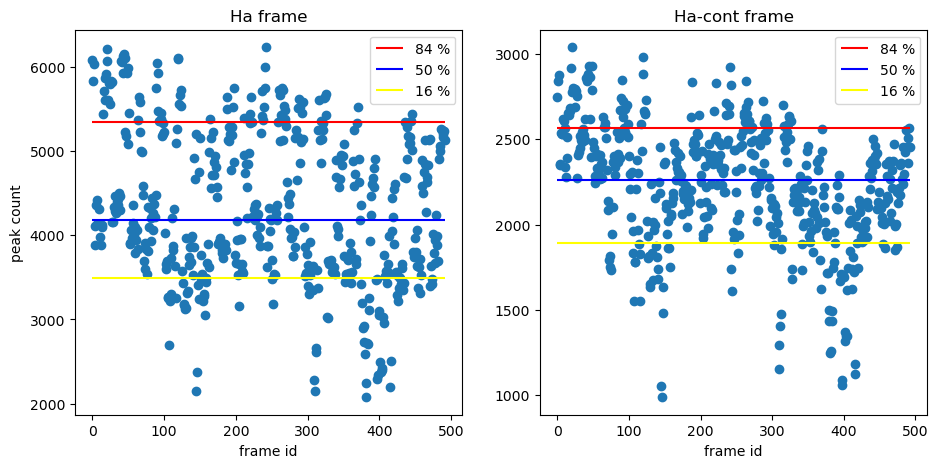

In [50]:
peak_Ha_list =[]; peak_Ha_cont_list=[]
for i in range(len(Ha_data)):
        peak_Ha = np.nanmax(Ha_data[i])
        peak_Ha_list.append(peak_Ha)
for i in range(len(Ha_cont_data)):
        peak_Ha_cont = np.nanmax(Ha_cont_data[i])
        peak_Ha_cont_list.append(peak_Ha_cont)

peak_Ha_list = np.array(peak_Ha_list)
peak_Ha_cont_list = np.array(peak_Ha_cont_list)


plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(range(len(Ha_data)),peak_Ha_list)
plt.hlines(y=np.percentile(peak_Ha_list,84),xmin=range(len(Ha_data))[0],xmax=range(len(Ha_data))[-1],color='red',label='84 %')
plt.hlines(y=np.percentile(peak_Ha_list,50),xmin=range(len(Ha_data))[0],xmax=range(len(Ha_data))[-1],color='blue',label='50 %')
plt.hlines(y=np.percentile(peak_Ha_list,16),xmin=range(len(Ha_data))[0],xmax=range(len(Ha_data))[-1],color='yellow',label='16 %')
plt.legend()
plt.xlabel('frame id')
plt.ylabel('peak count')
plt.title('Ha frame')

plt.subplot(1,2,2)
plt.scatter(range(len(Ha_cont_data)),peak_Ha_cont_list)
plt.hlines(y=np.percentile(peak_Ha_cont_list,84),xmin=range(len(Ha_cont_data))[0],xmax=range(len(Ha_cont_data))[-1],color='red',label='84 %')
plt.hlines(y=np.percentile(peak_Ha_cont_list,50),xmin=range(len(Ha_cont_data))[0],xmax=range(len(Ha_cont_data))[-1],color='blue',label='50 %')
plt.hlines(y=np.percentile(peak_Ha_cont_list,16),xmin=range(len(Ha_cont_data))[0],xmax=range(len(Ha_cont_data))[-1],color='yellow',label='16 %')
plt.legend()
plt.xlabel('frame id')
plt.title('Ha-cont frame')

## Depending on your interest, you need to tweak the threshold about what percentage you want to include. Peak can be referred as Strehl ratio (AO performance).
## It is a trade-off between the number of the total frames (background sensitivity, particularly at larger separations) and selecting better-AO exposures (contrast, particularly at inner separations)

## b-2) frame selection

## selection criteria - play by youself and see how the outcome differs by the threshold percentage!

In [56]:
# modify by yourself!
threshold_Ha = np.percentile(peak_Ha_list,70)
threshold_Ha_cont = np.percentile(peak_Ha_cont_list,70)

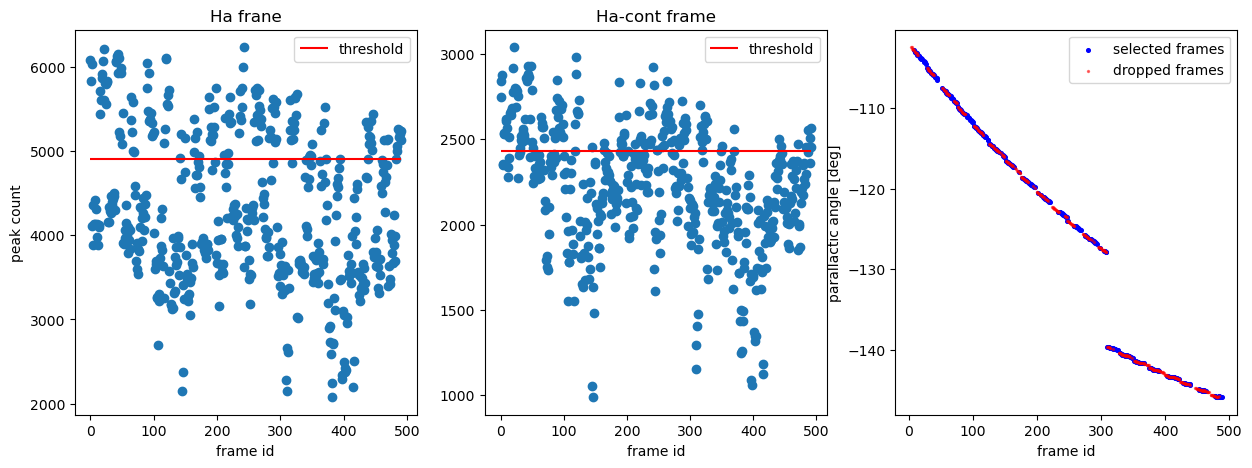

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(range(len(Ha_data)),peak_Ha_list)
plt.hlines(y=threshold_Ha,xmin=range(len(Ha_data))[0],xmax=range(len(Ha_data))[-1],color='red',label='threshold')
plt.legend()
plt.xlabel('frame id')
plt.ylabel('peak count')
plt.title('Ha frane')

plt.subplot(1,3,2)
plt.scatter(range(len(Ha_cont_data)),peak_Ha_cont_list)
plt.hlines(y=threshold_Ha_cont,xmin=range(len(Ha_cont_data))[0],xmax=range(len(Ha_cont_data))[-1],color='red',label='threshold')
plt.legend()
plt.xlabel('frame id')
plt.title('Ha-cont frame')

plt.subplot(1,3,3)
index=np.where(peak_Ha_list>threshold_Ha)[0]
Ha_parang_used = np.copy(Ha_parang)
Ha_parang_used[~index] = np.nan
Ha_parang_unused = np.copy(Ha_parang)
Ha_parang_unused[index] = np.nan
plt.scatter(range(len(Ha_parang)),Ha_parang_used,c='blue',s=7,label='selected frames')
plt.scatter(range(len(Ha_parang)),Ha_parang_unused,c='red',s=2,alpha=0.5,label='dropped frames')
plt.xlabel('frame id')
plt.ylabel('parallactic angle [deg]')
plt.legend()

### keep in mind that for ADI securing a sufficient field rotation provides a better result, you can check what parallactic angle the selected frame have in the third panel

### here we do frame selection based on the input selection criteria

In [59]:
Ha_data_selected = Ha_data[np.where(peak_Ha_list>threshold_Ha)]
Ha_cont_data_selected = Ha_cont_data[np.where(peak_Ha_cont_list>threshold_Ha_cont)]
    
Ha_parang_selected = Ha_parang[np.where(peak_Ha_list>threshold_Ha)]
Ha_cont_parang_selected = Ha_cont_parang[np.where(peak_Ha_cont_list>threshold_Ha_cont)]

#print(f'effective frame ratio - Ha:{len(Ha_data_selected)/Ha_totalframes}, Ha_cont: {len(Ha_cont_data_selected)/Ha_cont_totalframes}')
print(f'effective total exposure time [sec] - Ha: {Ha_totalexp*len(Ha_data_selected)/Ha_totalframes}, Ha_cont: {Ha_cont_totalexp*len(Ha_cont_data_selected)/Ha_cont_totalframes}')
print(f'nominal total exposure time w/o frame selection [sec] - Ha: {Ha_totalexp}, Ha_cont: {Ha_cont_totalexp}')

effective total exposure time [sec] - Ha: 578.0372670439025, Ha_cont: 578.0662038328601
nominal total exposure time w/o frame selection [sec] - Ha: 1921.5833472000004, Ha_cont: 1925.5853952000002


## c-1) set up the pyklip data class for ADI

### now you are almost ready to run ADI processing

In [60]:
fwhm=3.3 #pix, hardcoded but it is better to measure the FWHM from the combined PSF

# Ha
centers_Ha = [center]*len(Ha_parang_selected)
print(f'Ha field rotation: {abs(Ha_parang_selected[0]-Ha_parang_selected[-1])}')
iwa_Ha = calc_iwa(fwhm,np.deg2rad(abs(Ha_parang_selected[0]-Ha_parang_selected[-1])),N_delta)

dataset_Ha = Instrument.GenericData(Ha_data_selected, centers_Ha, parangs=Ha_parang_selected, IWA=iwa_Ha)

# Ha_cont
centers_Ha_cont = [center]*len(Ha_cont_parang_selected)
print(f'Ha-cont field rotation: {abs(Ha_cont_parang_selected[0]-Ha_cont_parang_selected[-1])}')
iwa_Ha_cont = calc_iwa(fwhm,np.deg2rad(abs(Ha_cont_parang_selected[0]-Ha_cont_parang_selected[-1])),N_delta)

dataset_Ha_cont = Instrument.GenericData(Ha_cont_data_selected, centers_Ha_cont, parangs=Ha_cont_parang_selected, IWA=iwa_Ha_cont)

Ha field rotation: 44.248443603515625
inner working angle is 3.4184446pix
Ha-cont field rotation: 44.248451232910156
inner working angle is 3.4184442pix


## c-2) run ADI processing

### Ha data

In [61]:
t1 = time.perf_counter()
parallelized.klip_dataset(dataset_Ha, outputdir=outdir_Ha, fileprefix=f"klip-ADI_thr{int(threshold_Ha)}", mode="ADI", \
                          annuli=annuli, annuli_spacing='linear', subsections=subsections, movement=movement,\
                          numbasis=numbasis, maxnumbasis=200, highpass=False)
print("{0} seconds to run ADI".format(time.perf_counter() - t1))

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Volumes/data_astro/analysis_VAMPIRES/tutorial/klip_output/Ha
wavelength collapsing reduced data of shape (b, N, wv, y, x):(7, 148, 1, 756, 756)
666.892050750088 seconds to run ADI


In [62]:
t2 = time.perf_counter()
parallelized.klip_dataset(dataset_Ha_cont, outputdir=outdir_Hacont, fileprefix=f"klip-ADI_thr{int(threshold_Ha_cont)}", mode="ADI", \
                          annuli=annuli, annuli_spacing='linear', subsections=subsections, movement=movement,\
                          numbasis=numbasis, maxnumbasis=200, highpass=False)
print("{0} seconds to run ADI".format(time.perf_counter() - t2))

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Volumes/data_astro/analysis_VAMPIRES/tutorial/klip_output/Ha-cont
wavelength collapsing reduced data of shape (b, N, wv, y, x):(7, 148, 1, 756, 756)
701.5538944583386 seconds to run ADI


## let's check the ADI residuals

output KL mode: 5


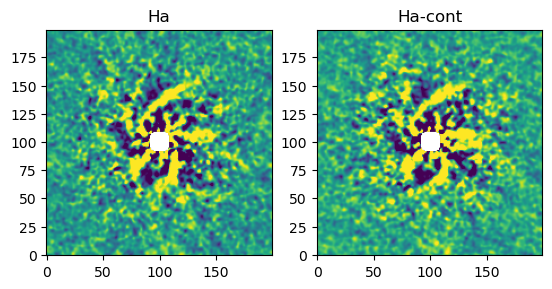

In [66]:
output_channel = 3
print(f'output KL mode: {numbasis[output_channel]}')
Ha_output = fits.getdata(glob(outdir_Ha+'klip-ADI*fits')[0])[output_channel]
Ha_cont_output = fits.getdata(glob(outdir_Hacont+'klip-ADI*fits')[0])[output_channel]

Ha_smooth = gaussian_filter(Ha_output,sigma=fwhm/2.5) # usually sigma=fwhm/2.355
Ha_cont_smooth = gaussian_filter(Ha_cont_output,sigma=fwhm/2.5)

ycen, xcen = int(center[1]), int(center[0])
plt.subplot(1,2,1)
plt.title('Ha')
plt.imshow(Ha_smooth[ycen-100:ycen+100,xcen-100:xcen+100],origin='lower',\
           vmin=np.nanpercentile(Ha_smooth,1),vmax=np.nanpercentile(Ha_smooth,99))
plt.subplot(1,2,2)
plt.title('Ha-cont')
plt.imshow(Ha_cont_smooth[ycen-100:ycen+100,xcen-100:xcen+100],origin='lower',\
           vmin=np.nanpercentile(Ha_cont_smooth,1),vmax=np.nanpercentile(Ha_cont_smooth,99))

## you see teh spiral features at both Ha and Ha-cont filters, but they are basically scattered light
## if you want to search for Ha-only emission, let's subtract Ha-cont from Ha image

## d) apply SDI to the ADI residuals

### first calculate the coefficient to scale the Ha-cont image as a reference PSF for SDI
### make a combined PSF from the selected frames

In [69]:
Ha_comb = np.nanmedian(Ha_data_selected,axis=0)
Ha_cont_comb = np.nanmedian(Ha_cont_data_selected,axis=0)

/var/folders/c9/nkyq95q510xblvbx7f5zlgxc0000gp/T/ipykernel_34089/2164463533.py:2: RuntimeWarning: All-NaN slice encountered
  Ha_comb = np.nanmedian(Ha_data_selected,axis=0)


1.0


/var/folders/c9/nkyq95q510xblvbx7f5zlgxc0000gp/T/ipykernel_34089/2164463533.py:3: RuntimeWarning: All-NaN slice encountered
  Ha_cont_comb = np.nanmedian(Ha_cont_data_selected,axis=0)


### for simplicity, estimate a scaling factor as a ratio between the peaks of the Ha and Ha-cont combiend PSF

In [70]:
peak_Ha_comb = np.nanmax(Ha_comb)
peak_Ha_cont_comb = np.nanmax(Ha_cont_comb)

scale_fac = peak_Ha_comb/peak_Ha_cont_comb
print(scale_fac)

2.0914505


### apply this factor to the Ha-cont ADI residual and then subtract from the Ha ADI residual

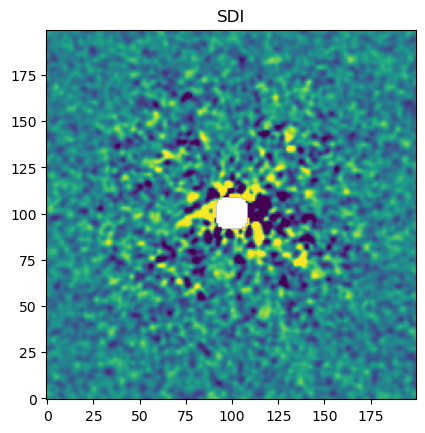

In [73]:
ref_SDI = scale_fac*Ha_cont_output
SDI_output = Ha_output - ref_SDI
SDI_smooth = gaussian_filter(SDI_output,sigma=fwhm/2.5)

plt.title('SDI')
plt.imshow(SDI_smooth[ycen-100:ycen+100,xcen-100:xcen+100],origin='lower',\
           vmin=np.nanpercentile(SDI_smooth,0.5),vmax=np.nanpercentile(SDI_smooth,99.5))